In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats, special

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [143]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style('white')
plt.rc('figure',figsize=(18,10))
plt.rc('font',size=16)

### __Part 1: Load Data__

In [5]:
installations = pd.read_csv('output.csv.gz')

/home/aydin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10,11,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
installations.shape

(1844487, 20)

In [7]:
installations.head()

installation_date  system_size_DC  total_installed_price  \
0  03-Feb-2009 00:00:00            8.64               57162.77   
1  26-Jan-2009 00:00:00            3.40               26507.20   
2  15-Oct-2008 00:00:00            4.80               36292.00   
3  02-Feb-2009 00:00:00            1.52               13230.00   
4  30-Mar-2009 00:00:00            5.10               40370.32   

   rebate_or_grant customer_segment  expansion_system  multiple_phase_system  \
0          25920.0              RES                 0                      0   
1          10500.0              RES                 0                      0   
2          12960.0              RES                 0                      0   
3           4560.0              RES                 0                      0   
4          15300.0              RES                 0                      0   

   new_construction  tracking  ground_mounted zip_code        city state  \
0               NaN       NaN             NaN    85262  Scottsdale    AZ   
1               NaN       NaN             NaN    85373    Sun City    AZ   
2               NaN       NaN             NaN    86333       Mayer    AZ   
3               NaN       NaN             NaN    85603      Bisbee    AZ   
4               NaN       NaN             NaN    85388    Surprise    AZ   

   self_installed technology_module_1 technology_module_2 technology_module_3  \
0             NaN                Poly                 NaN                 NaN   
1             NaN          Multi-c-Si                 NaN                 NaN   
2             NaN                Poly                 NaN                 NaN   
3             NaN                Poly                 NaN                 NaN   
4             NaN          Multi-c-Si                 NaN                 NaN   

   efficiency_module_1  efficiency_module_2  efficiency_module_3  
0             0.143590                  NaN                  NaN  
1             0.130674                  NaN                  NaN  
2             0.141844                  NaN                  NaN  
3             0.127517                  NaN                  NaN  
4             0.130674                  NaN                  NaN

In [8]:
# checking list of columns
installations.columns

Index(['installation_date', 'system_size_DC', 'total_installed_price',
       'rebate_or_grant', 'customer_segment', 'expansion_system',
       'multiple_phase_system', 'new_construction', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'state', 'self_installed',
       'technology_module_1', 'technology_module_2', 'technology_module_3',
       'efficiency_module_1', 'efficiency_module_2', 'efficiency_module_3'],
      dtype='object')

In [9]:
installations['customer_segment'].value_counts()/1844487

RES           0.952124
COM           0.019627
NON-RES       0.009777
GOV           0.002763
NON-PROFIT    0.002075
SCHOOL        0.001846
Name: customer_segment, dtype: float64

In [10]:
installations.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844487 entries, 0 to 1844486
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   installation_date      1844487 non-null  object 
 1   system_size_DC         1830826 non-null  float64
 2   total_installed_price  1421842 non-null  float64
 3   rebate_or_grant        1692702 non-null  float64
 4   customer_segment       1822746 non-null  object 
 5   expansion_system       1844487 non-null  int64  
 6   multiple_phase_system  1844487 non-null  int64  
 7   new_construction       313852 non-null   float64
 8   tracking               1156224 non-null  float64
 9   ground_mounted         917047 non-null   float64
 10  zip_code               1758554 non-null  object 
 11  city                   1699387 non-null  object 
 12  state                  1844487 non-null  object 
 13  self_installed         1451891 non-null  float64
 14  technology_module_

In [11]:
installations = installations[installations.system_size_DC != 424000 ] # erroneous systems size was removed

In [12]:
#changing format of installation date
installations['installation_date'] = pd.to_datetime(installations['installation_date'],utc=True).dt.strftime('%Y-%m-%d %H:%M:%S.%f')
installations['installation_date'] = pd.to_datetime(installations['installation_date'],utc=True)
#set installation date as index
installations.sort_values('installation_date', inplace=True)
installations.set_index('installation_date', drop=False, inplace=True)

In [13]:
installations.drop(columns=['installation_date'], inplace=True)

### __Part 2: Installation numbers__

In [14]:
# groupby_installs = df.groupby('installation_date').count()
number_installs = pd.DataFrame(installations.index.value_counts()).rename(columns={'installation_date':'installation_numbers'})
number_installs.columns

Index(['installation_numbers'], dtype='object')

In [15]:
type(number_installs)

pandas.core.frame.DataFrame

In [16]:
number_installs['date'] = number_installs.index.date
number_installs['year'] = number_installs.index.year

In [17]:
number_installs.sort_values('date', inplace=True)

In [18]:
number_installs

installation_numbers        date  year
1998-01-30 00:00:00+00:00                     1  1998-01-30  1998
1998-02-04 00:00:00+00:00                     1  1998-02-04  1998
1998-02-28 00:00:00+00:00                     1  1998-02-28  1998
1998-03-01 00:00:00+00:00                     1  1998-03-01  1998
1998-04-01 00:00:00+00:00                     1  1998-04-01  1998
...                                         ...         ...   ...
2019-12-27 00:00:00+00:00                  1354  2019-12-27  2019
2019-12-28 00:00:00+00:00                   223  2019-12-28  2019
2019-12-29 00:00:00+00:00                    81  2019-12-29  2019
2019-12-30 00:00:00+00:00                  1243  2019-12-30  2019
2019-12-31 00:00:00+00:00                  1142  2019-12-31  2019

[6905 rows x 3 columns]

In [19]:
total_daily=number_installs.resample('D').sum()
total_daily.year=total_daily.index.year

In [20]:
total_daily.shape

(8006, 2)

In [21]:
# 1101 days with zero installations
sum(total_daily.installation_numbers==0)

1101

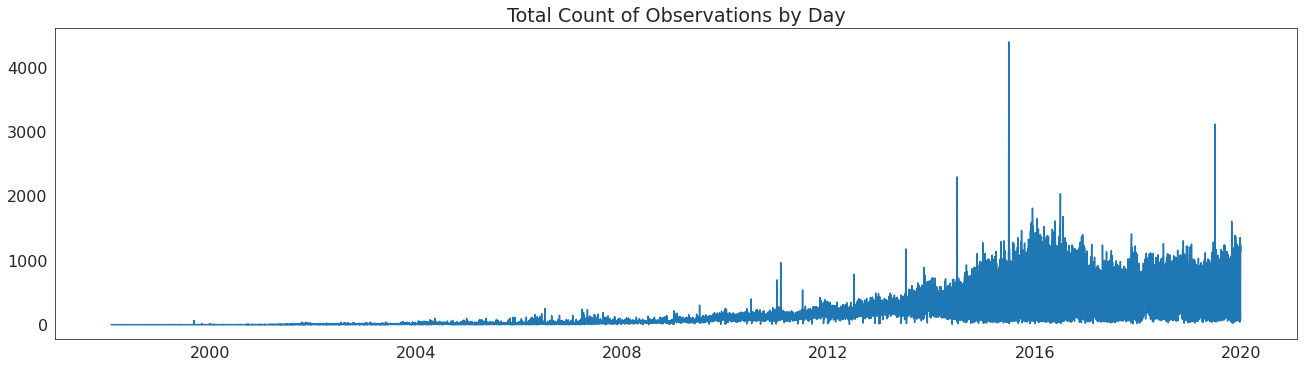

In [22]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(total_daily.index.date,total_daily.resample('D').sum()['installation_numbers'])
#plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.title('Total Count of Observations by Day')
plt.show()

In [23]:
total_monthly=number_installs.resample('M').sum()
total_monthly.year=total_monthly.index.year

In [24]:
# no month with zero installations
sum(total_monthly.installation_numbers==0)

0

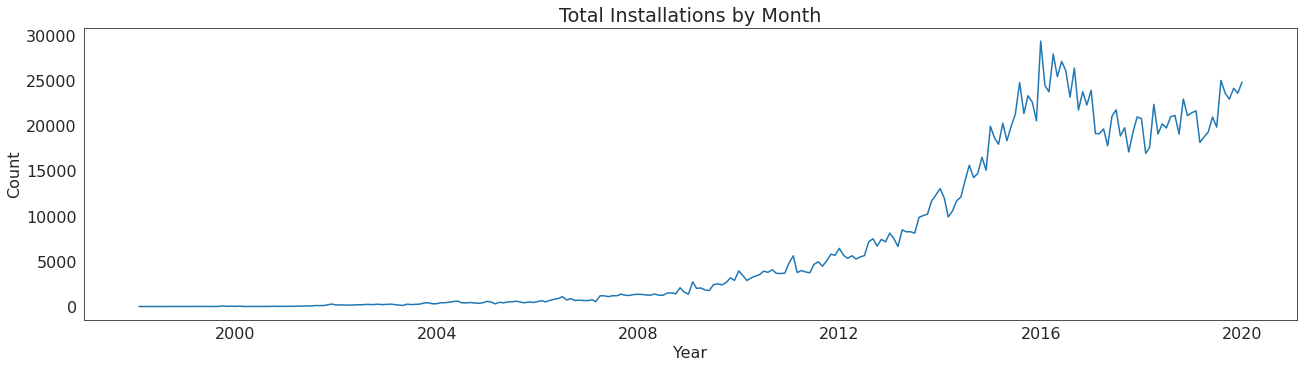

In [169]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(total_monthly.index.date,total_monthly['installation_numbers'])
# ax.set_xticks(np.linspace(ax.get_xticks()[1], ax.get_xticks()[-2], 12))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.title('Total Installations by Month')
ax.set_ylabel("Count" )
ax.set_xlabel("Year")
plt.show()
fig.savefig('../images/counts.png')

In [26]:
total_week=number_installs.resample('W').sum()
total_week.year=total_week.index.year

In [27]:
sum(total_week.installation_numbers==0)

40

In [28]:
total_week

installation_numbers  year
1998-02-01 00:00:00+00:00                     1  1998
1998-02-08 00:00:00+00:00                     1  1998
1998-02-15 00:00:00+00:00                     0  1998
1998-02-22 00:00:00+00:00                     0  1998
1998-03-01 00:00:00+00:00                     2  1998
...                                         ...   ...
2019-12-08 00:00:00+00:00                  5770  2019
2019-12-15 00:00:00+00:00                  5928  2019
2019-12-22 00:00:00+00:00                  5901  2019
2019-12-29 00:00:00+00:00                  4713  2019
2020-01-05 00:00:00+00:00                  2385  2020

[1145 rows x 2 columns]

In [157]:
ax.get_xticks()[2]

731581.0

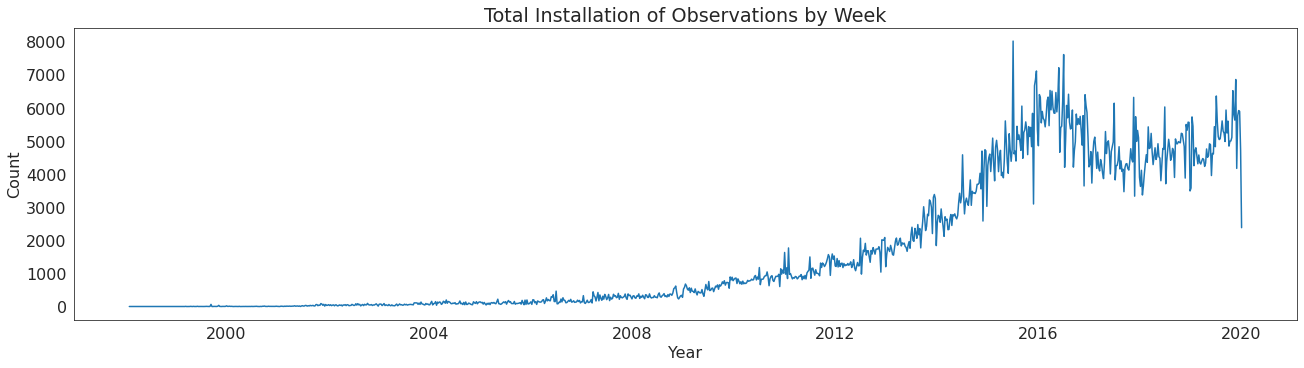

In [150]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(total_week.index.date,total_week['installation_numbers'])
#ax.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.title('Total Installation of Observations by Week')
ax.set_ylabel("Count" )
ax.set_xlabel("Year")
plt.show()

### __Part 4: Monthly DC Output of Installed Panels__

In [30]:
monthly_output = installations[['system_size_DC']].resample('M').sum()
#monthly_output[(monthly_output==monthly_output.max()).system_size_DC]

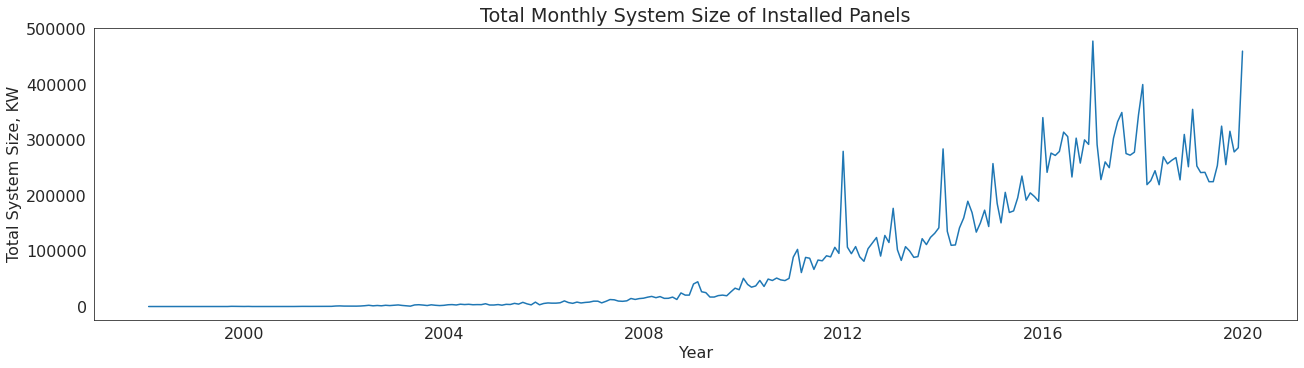

In [246]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(monthly_output.index.date, monthly_output)
plt.title('Total Monthly System Size of Installed Panels')
ax.set_ylabel("Total System Size, KW" )
ax.set_xlabel("Year")
plt.show()
fig.savefig('../images/kw_output.png')

### __Part 5: Decomposition of time series__

#### __Part 5.1: Decomposition of time series on number on installations__

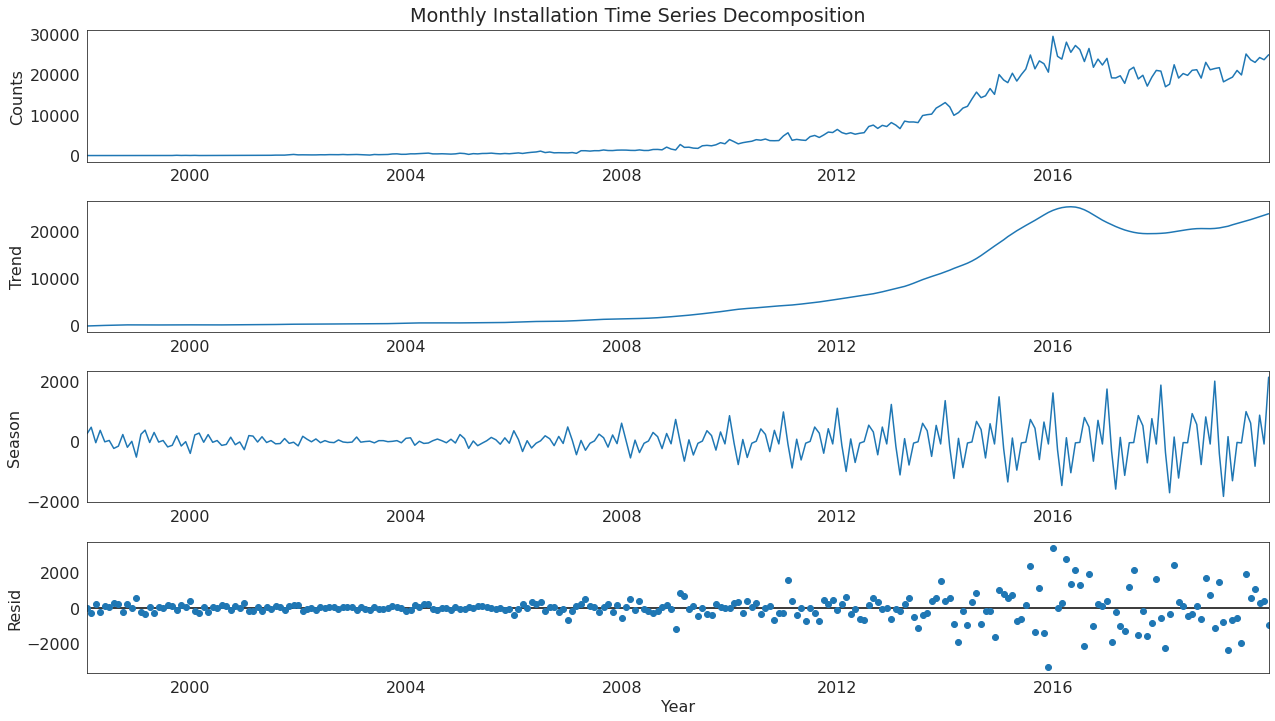

In [144]:
stl = STL(total_monthly.installation_numbers, seasonal=53)
res = stl.fit()
fig = res.plot()
fig.suptitle('Monthly Installation Time Series Decomposition')
ax=fig.get_axes()
ax[0].set_title('')
ax[0].set_ylabel('Counts')
plt.xlabel("Year")
fig.savefig('../images/installations_decompose.png')

#### __Part 5.2: Decomposition of time series for total monthly system size in KW__

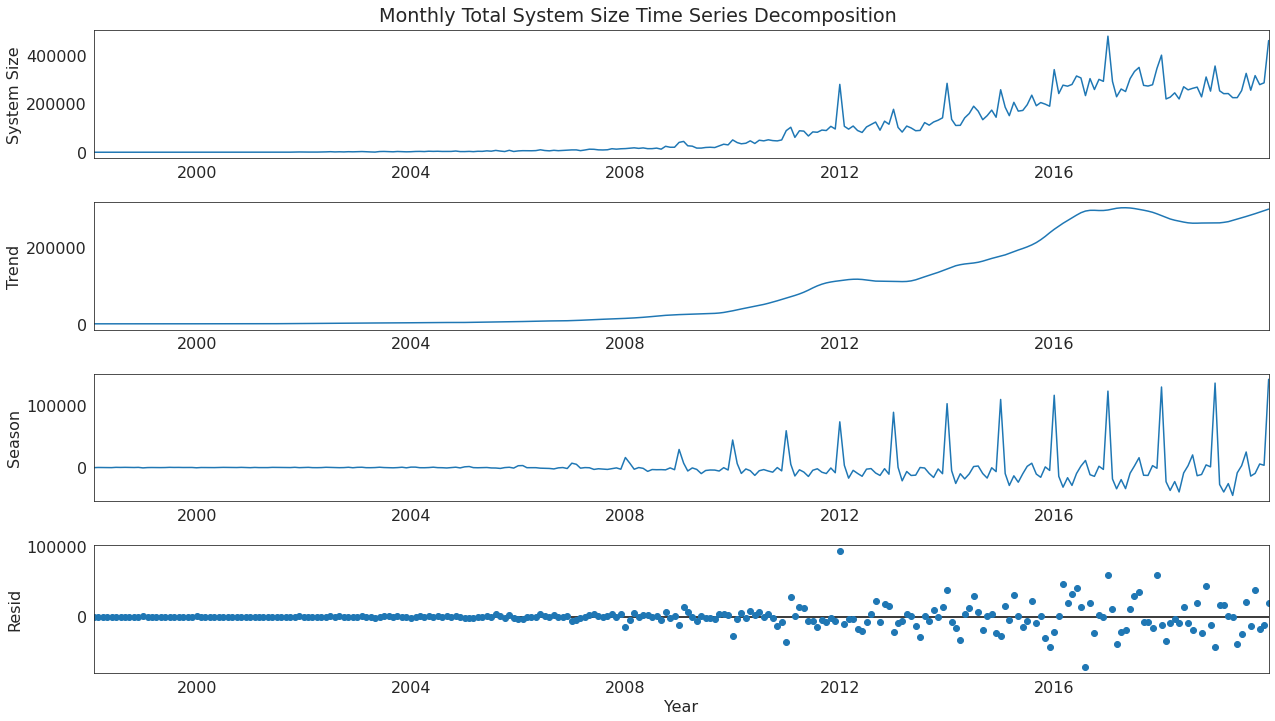

In [174]:
stl = STL(monthly_output.system_size_DC, seasonal=13)
res = stl.fit()
fig = res.plot()
fig.suptitle('Monthly Total System Size Time Series Decomposition')
ax=fig.get_axes()
ax[0].set_title('')
ax[0].set_ylabel('System Size')
plt.xlabel("Year")
fig.savefig('../images/kw_decompose.png')

### __Part 6: Arima Model__

#### __Part 6.1: Arima Model On number on installations__

In [34]:
from pandas.plotting import autocorrelation_plot

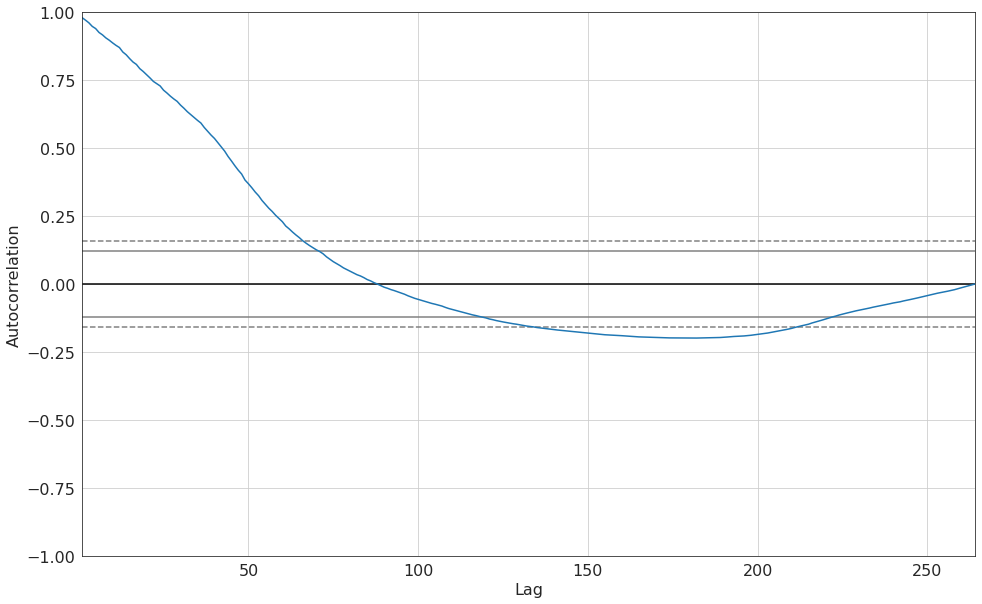

In [35]:
autocorrelation_plot(total_monthly)

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

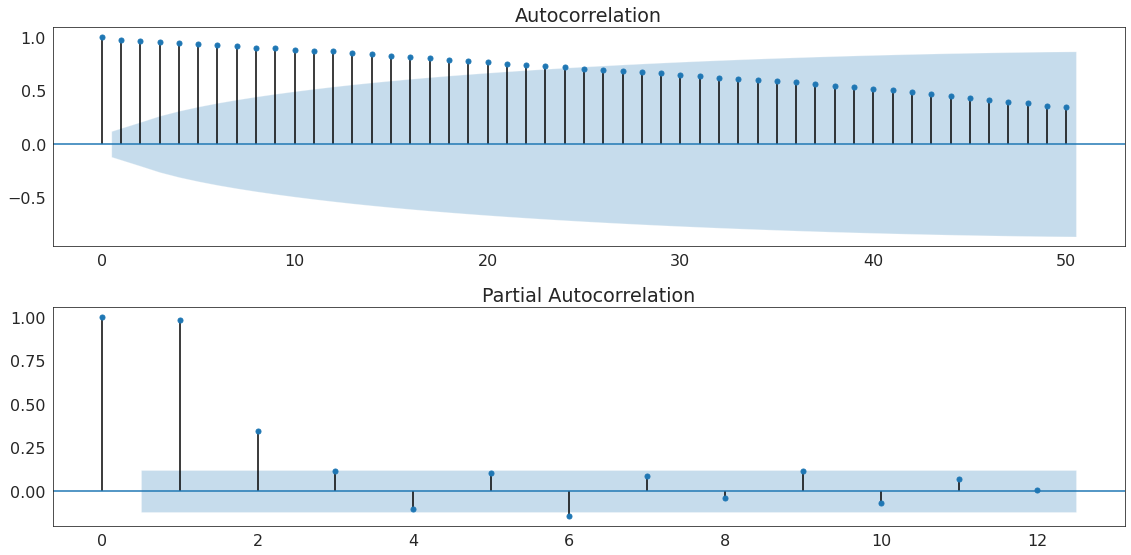

In [37]:
fig, axs = plt.subplots(2, figsize=(16, 8))
_ = plot_acf(total_monthly.installation_numbers, ax=axs[0], lags = 50)
_ = plot_pacf(total_monthly.installation_numbers, ax=axs[1], lags= 12)
plt.tight_layout()

In [38]:
monthly_difference = total_monthly.installation_numbers.diff(periods=1)

In [39]:
monthly_difference

1998-01-31 00:00:00+00:00       NaN
1998-02-28 00:00:00+00:00       1.0
1998-03-31 00:00:00+00:00      -1.0
1998-04-30 00:00:00+00:00       1.0
1998-05-31 00:00:00+00:00       1.0
                              ...  
2019-08-31 00:00:00+00:00   -1422.0
2019-09-30 00:00:00+00:00    -646.0
2019-10-31 00:00:00+00:00    1197.0
2019-11-30 00:00:00+00:00    -542.0
2019-12-31 00:00:00+00:00    1223.0
Freq: M, Name: installation_numbers, Length: 264, dtype: float64

In [40]:
test = sm.tsa.stattools.adfuller(monthly_difference[172:])
print("ADF p-value: {0:2.2f}".format(test[1]))
test_kpss = sm.tsa.stattools.kpss(monthly_difference[172:])
print("KPSS p-value: {0:2.2f}".format(test_kpss[1])) # is not station as both tests show it

ADF p-value: 0.00
KPSS p-value: 0.10


/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


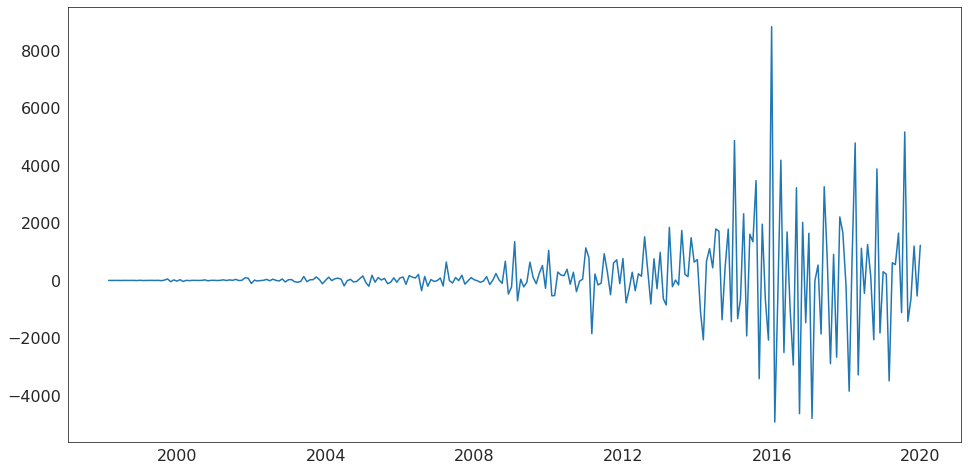

In [41]:
fig, axs = plt.subplots(1, figsize=(16, 8))
axs.plot(monthly_difference.index.date, monthly_difference)

In [42]:
monthly_difference_2=monthly_difference.diff(1)

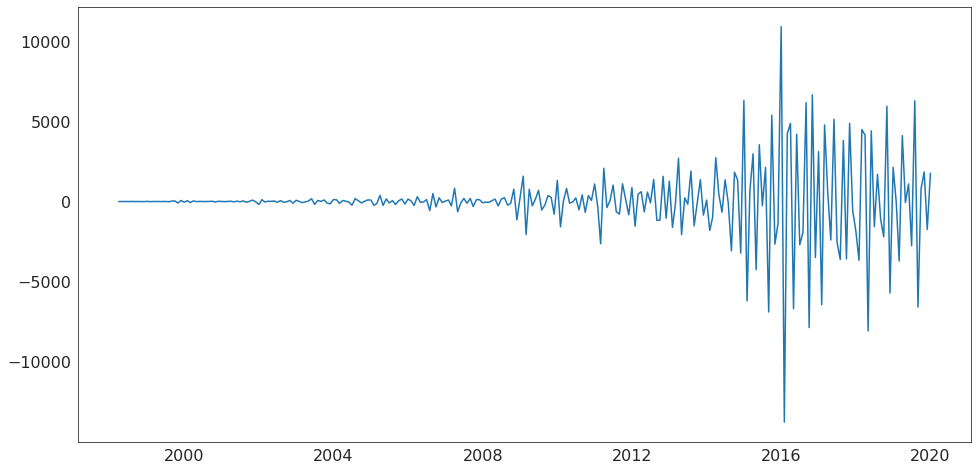

In [43]:
fig, axs = plt.subplots(1, figsize=(16, 8))
axs.plot(monthly_difference_2.index.date, monthly_difference_2)

In [44]:
test = sm.tsa.stattools.adfuller(monthly_difference_2[2:])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00


In [45]:
split_point = len(total_monthly.installation_numbers) - 12
y_train = total_monthly.installation_numbers[0:split_point]
y_test = total_monthly.installation_numbers[split_point:]

In [46]:
model = ARIMA(y_train, order=(25,2,10))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                SARIMAX Results                                 
Dep. Variable:     installation_numbers   No. Observations:                  252
Model:                 ARIMA(25, 2, 10)   Log Likelihood               -2040.085
Date:                  Tue, 12 Jan 2021   AIC                           4152.169
Time:                          17:03:26   BIC                           4278.942
Sample:                      01-31-1998   HQIC                          4203.191
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5951      1.628     -0.366      0.715      -3.785       2.595
ar.L2         -0.7207      1.278     -0.564      0.573      -3.225       1.784
ar.L3         -0.6568      1.306    

In [47]:
forecast = model_fit.forecast()[0]

In [48]:
forecast_48_months = model_fit.forecast(48)
pred_12 = model_fit.predict(y_test.index.min(),y_test.index.max())

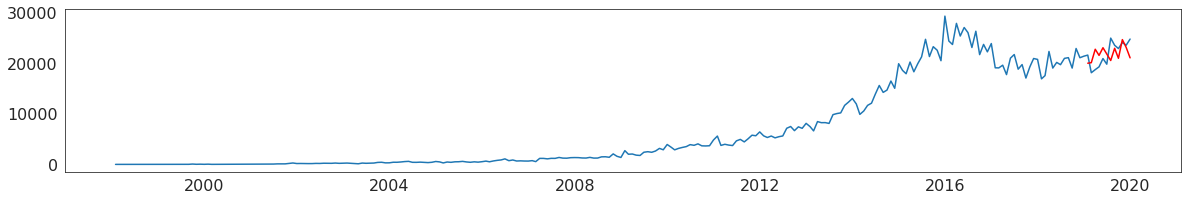

In [49]:
# y_hat=arma_res.predict(total_monthly.index.max(), pd.to_datetime('2024-06-01').tz_localize('UTC'))
fig, ax = plt.subplots(1, figsize=(20, 3))
ax.plot(total_monthly.index.values, total_monthly.installation_numbers)
#ax.plot(y_next.index.values, y_next, color='r')
ax.plot(pred_12.index.values, pred_12, color='r');

In [50]:
rmse = mse(y_test, pred_12, squared=False)
mean_avg_error = mae(y_test, pred_12)
print(f'RMSE = {rmse}, MAE = {mean_avg_error}')

RMSE = 2497.1975286456686, MAE = 2146.854528534377


#### __Part 6.2: Arima model on total monthly system size in KW__

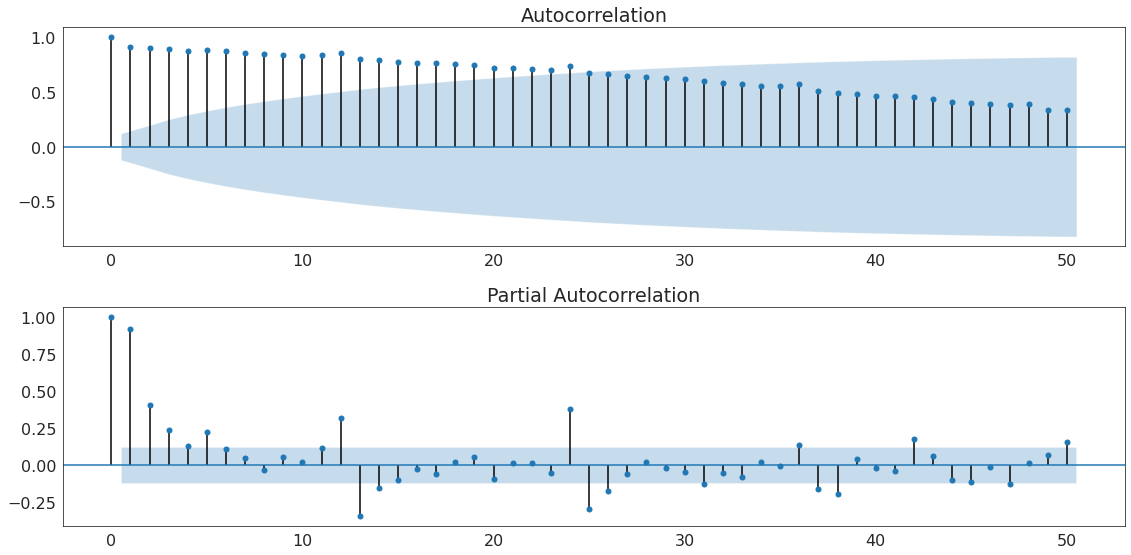

In [51]:
fig, axs = plt.subplots(2, figsize=(16, 8))
_ = plot_acf(monthly_output.system_size_DC, ax=axs[0], lags = 50)
_ = plot_pacf(monthly_output.system_size_DC, ax=axs[1], lags= 50)
plt.tight_layout()

In [52]:
monthly_output_difference=monthly_output.system_size_DC.diff(1)
monthly_output_difference_2=monthly_output_difference.diff(1)
#monthly_output_difference_2=monthly_output.system_size_DC.diff(2)

In [53]:
test_adf = sm.tsa.stattools.adfuller(monthly_output_difference[172:])
print("ADF p-value: {0:2.2f}".format(test_adf[1]))
test_kpss = sm.tsa.stattools.kpss(monthly_output_difference[172:])
print("KPSS p-value: {0:2.2f}".format(test_kpss[1])) # is not station as both tests show it

ADF p-value: 0.02
KPSS p-value: 0.10


/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [54]:
test_adf = sm.tsa.stattools.adfuller(monthly_output_difference_2[172:])
print("ADF p-value: {0:2.2f}".format(test_adf[1]))
test_kpss = sm.tsa.stattools.kpss(monthly_output_difference_2[172:])
print("KPSS p-value: {0:2.2f}".format(test_kpss[1])) # is not station as both tests show it

ADF p-value: 0.00
KPSS p-value: 0.10


/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


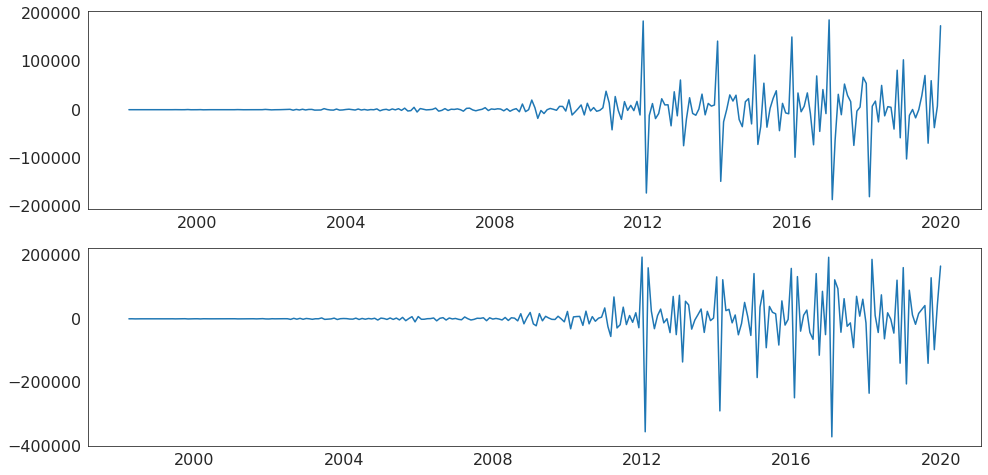

In [55]:
fig, axs = plt.subplots(2, figsize=(16, 8))
axs[0].plot(monthly_output_difference.index.date, monthly_output_difference)
axs[1].plot(monthly_output_difference_2.index.date, monthly_output_difference_2)

In [56]:
split_point = len(monthly_output.system_size_DC) - 12
y_train = monthly_output.system_size_DC[0:split_point]
y_test = monthly_output.system_size_DC[split_point:]

In [57]:
model_KW = ARIMA(y_train, order=(25,2,10))
model_fit_KW = model_KW.fit()
# print summary of fit model
print(model_fit_KW.summary())

/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/aydin/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:         system_size_DC   No. Observations:                  252
Model:               ARIMA(25, 2, 10)   Log Likelihood               -2842.912
Date:                Tue, 12 Jan 2021   AIC                           5757.824
Time:                        17:03:35   BIC                           5884.596
Sample:                    01-31-1998   HQIC                          5808.846
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8995      0.658     -1.367      0.172      -2.190       0.391
ar.L2         -0.9326      0.446     -2.090      0.037      -1.807      -0.058
ar.L3         -1.1999      0.492     -2.438      0.0

In [58]:
forecast_48_months_KW = model_fit_KW.forecast(48)
pred_12_KW = model_fit_KW.predict(y_test.index.min(),y_test.index.max())

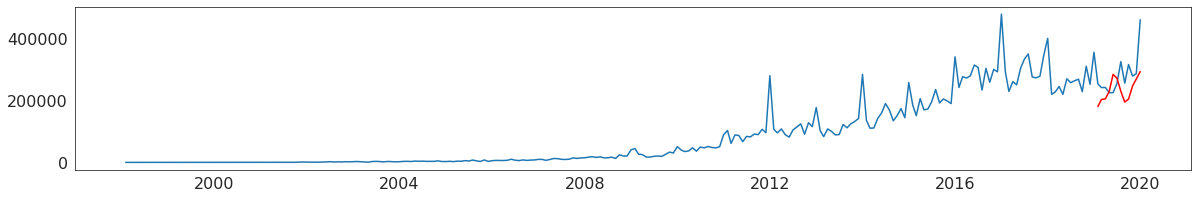

In [59]:
fig, ax = plt.subplots(1, figsize=(20, 3))
ax.plot(monthly_output.index.values, monthly_output.system_size_DC)
ax.plot(pred_12_KW.index.values, pred_12_KW, color='r');

In [60]:
rmse = mse(y_test, pred_12_KW, squared=False)
mean_avg_error = mae(y_test, pred_12_KW)
print(f'RMSE = {rmse}, MAE = {mean_avg_error}')

RMSE = 74433.18864367856, MAE = 59468.62387423086


#### __Part 6.3: Arima model on total monthly system size in KW transformed__

In [61]:
from_2011 = monthly_output[monthly_output.index.date > pd.Timestamp(year=2011, month=2, day=27)]

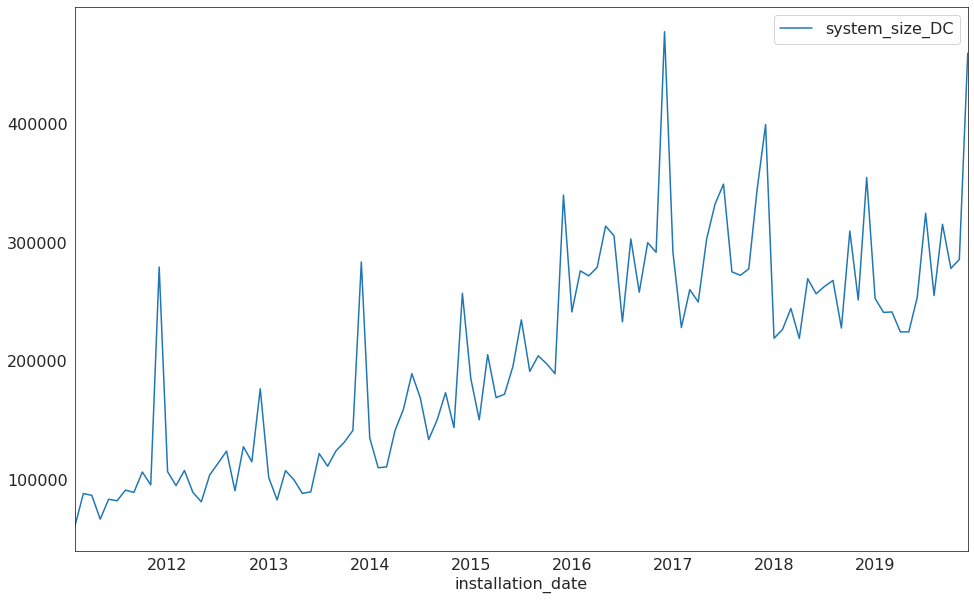

In [62]:
from_2011.plot()

In [63]:
from_2011_box_cox, lmbda = stats.boxcox(from_2011.system_size_DC)
from_2011_box_cox=pd.Series(from_2011_box_cox, index= from_2011.index)

In [64]:
lmbda

0.3869941401273204

In [185]:
type(fig.set_ylabel)

method

__Difference Plot for transformed data__

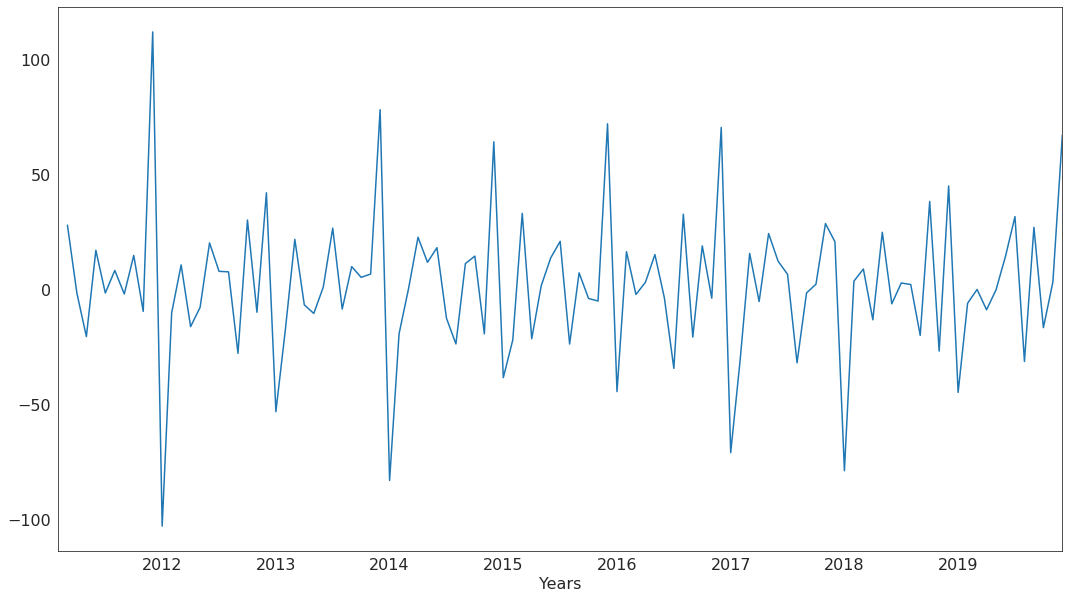

In [191]:
fig = (from_2011_box_cox.diff()).plot()
fig.set_xlabel('Years')
fig.get_figure().savefig('../images/diff_box_plot.png')

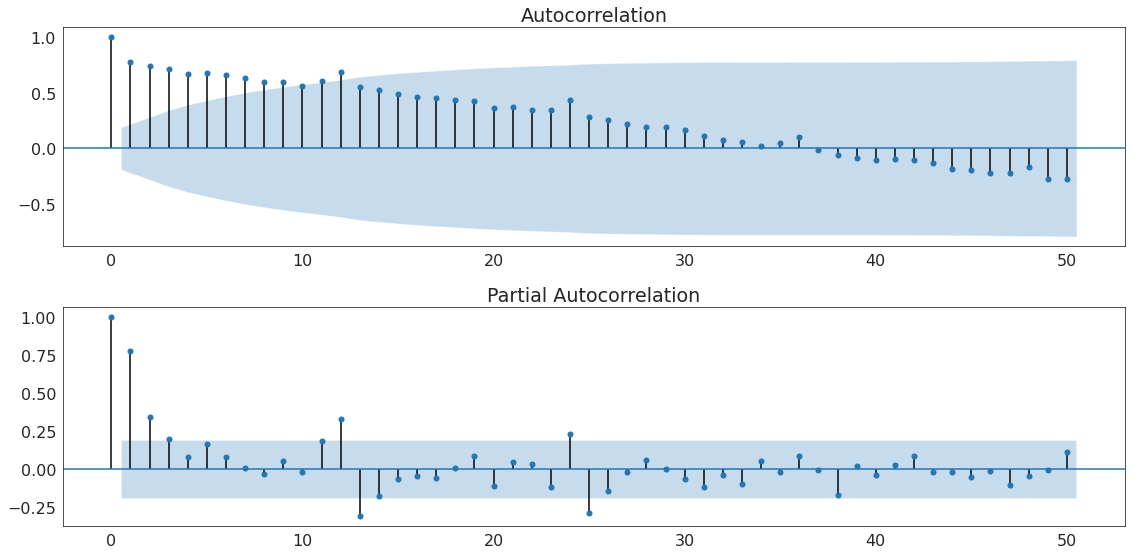

In [175]:
fig, axs = plt.subplots(2, figsize=(16, 8))
_ = plot_acf(from_2011_box_cox, ax=axs[0], lags = 50)
_ = plot_pacf(from_2011_box_cox, ax=axs[1], lags= 50, method='ywmle')
plt.tight_layout()
fig.savefig('../images/acf_pacf_box_plot.png')

In [67]:
split_point = len(from_2011_box_cox) - 12
transformed_train = from_2011_box_cox[0:split_point]
transformed_test= from_2011_box_cox[split_point:]

model_transformed = ARIMA(transformed_train, order=(2,1,0))
model_transformed_fit = model_transformed.fit()
pred_transformed = model_transformed_fit.predict(transformed_test.index.min(),transformed_test.index.max())

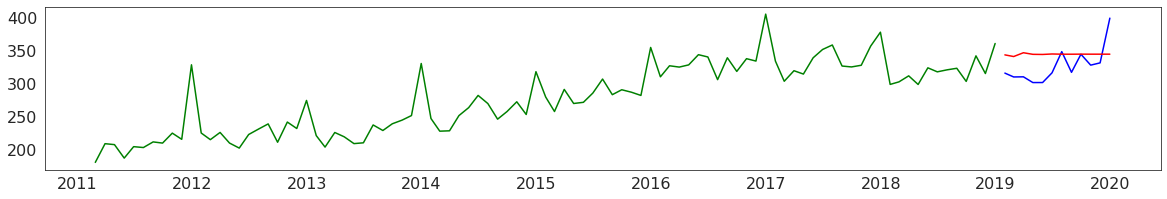

In [68]:
fig, ax = plt.subplots(1, figsize=(20, 3))
ax.plot(transformed_train.index.values, transformed_train, color='g')
ax.plot(transformed_test.index.values, transformed_test, color='b')
ax.plot(pred_transformed.index.values, pred_transformed, color='r');

In [69]:
rmse = mse(transformed_test, pred_transformed, squared=False)
mean_avg_error = mae(transformed_test, pred_transformed)
print(f'RMSE = {rmse}, MAE = {mean_avg_error}')

RMSE = 31.082226018864827, MAE = 26.93280296829697


In [70]:
mse(special.inv_boxcox(pred_transformed, lmbda),from_2011[split_point:], squared=False)

71417.13158109062

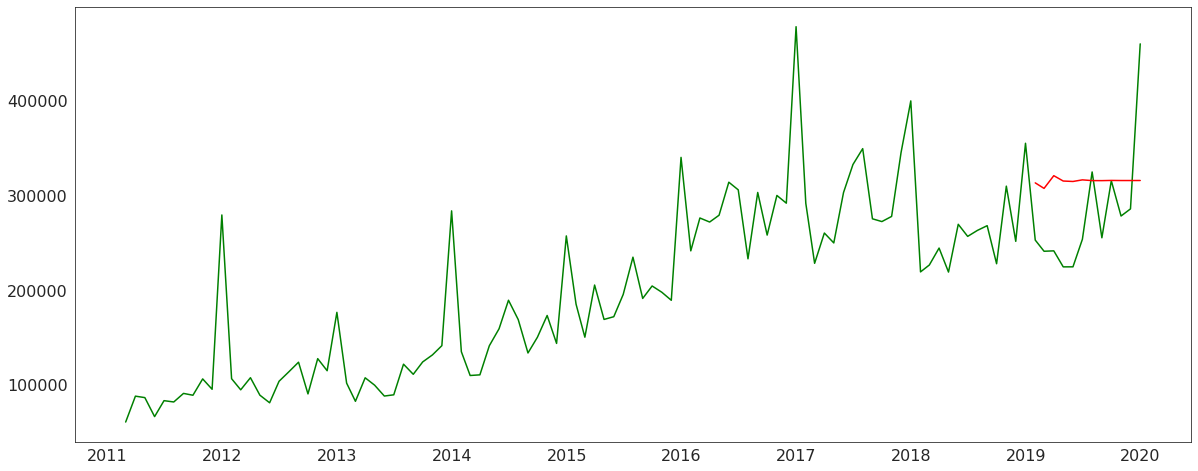

In [71]:
#special.inv_boxcox(pred_transformed, lmbda)
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(from_2011.index.values, from_2011, color='g')
ax.plot(pred_transformed.index.values, special.inv_boxcox(pred_transformed, lmbda), color='r');

#### __Part 7: SARIMA Model__

Using this variables from previous part: _from_2011, from_2011_box_cox, transformed_train, transformed_test_

In [288]:
sarima=SARIMAX(from_2011_box_cox, order=(2,1,0), seasonal_order=(2,1,0,12), )#simple_differencing=True)
sarima_fit= sarima.fit()
pred_sarima = sarima_fit.predict(transformed_test.index.min(),transformed_test.index.max())

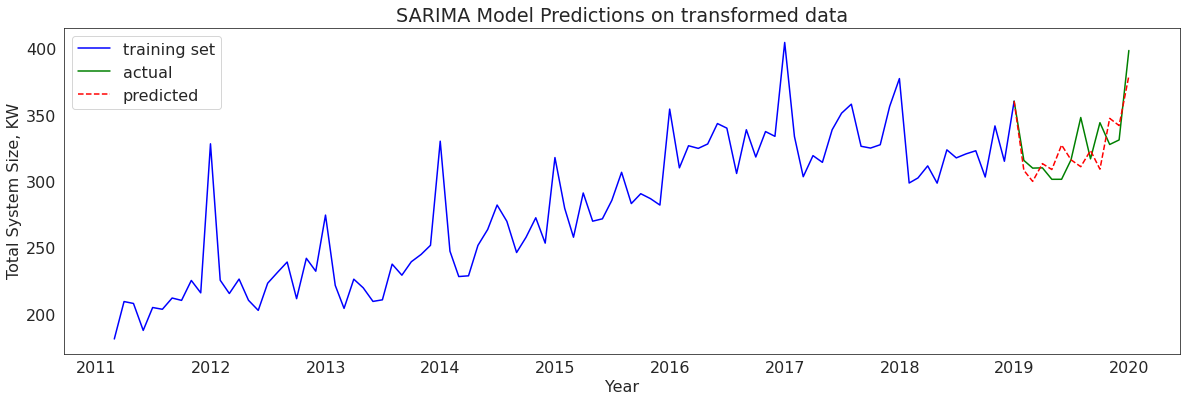

In [289]:
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.plot(transformed_train.index.values, transformed_train, color='b', label = 'training set')
# ax.plot(transformed_test.index.values, transformed_test, color='g', label = 'actual')

ax.plot(np.concatenate((transformed_train.index.values[-1], transformed_test.index.values),axis=None), 
        np.concatenate((transformed_train[-1], transformed_test),axis=None), color='g', label='actual')

ax.plot(np.concatenate((transformed_train.index.values[-1], pred_sarima.index.values),axis=None), 
        np.concatenate((transformed_train[-1], pred_sarima),axis=None), linestyle='--',color='r', label='predicted')
ax.set_ylabel("Total System Size, KW" )
ax.set_xlabel("Year")
ax.set_title('SARIMA Model Predictions on transformed data')
ax.legend()


In [290]:
y_2011_train=from_2011.system_size_DC[0:split_point]
y_2011_test=from_2011.system_size_DC[split_point:]
y_2011_pred=special.inv_boxcox(pred_sarima, lmbda)

In [291]:
np.concatenate((from_2011.system_size_DC[0:split_point][-1], from_2011[split_point:]),axis=None)

array([354837.90870602, 252825.9149634 , 241063.64194365, 241490.10642919,
       224616.77185345, 224656.18821596, 253671.78578097, 324608.44332511,
       255256.20264943, 315368.78105794, 278197.10792424, 285702.36413116,
       459562.55344306])

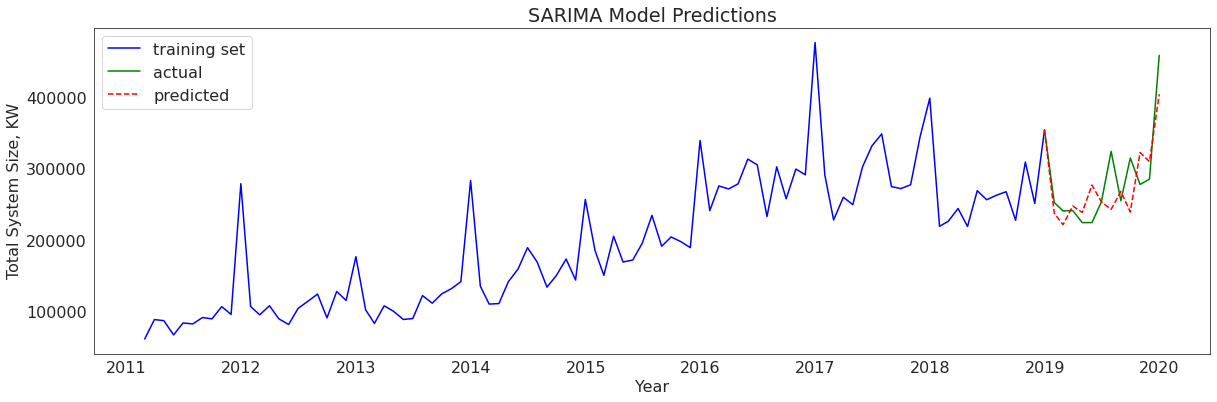

In [292]:
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.plot(y_2011_train.index.values, y_2011_train, color='b', label = 'training set')
ax.plot(np.concatenate((y_2011_train.index.values[-1], y_2011_test.index.values),axis=None), 
        np.concatenate((y_2011_train[-1], y_2011_test),axis=None), color='g', label='actual')

ax.plot(np.concatenate((y_2011_train.index.values[-1], y_2011_pred.index.values),axis=None), 
        np.concatenate((y_2011_train[-1], y_2011_pred),axis=None), linestyle='--', color='r', label='predicted')
ax.set_ylabel("Total System Size, KW" )
ax.set_xlabel("Year")
ax.set_title('SARIMA Model Predictions')
ax.legend()
fig.savefig('../images/sarima_prediction.png')

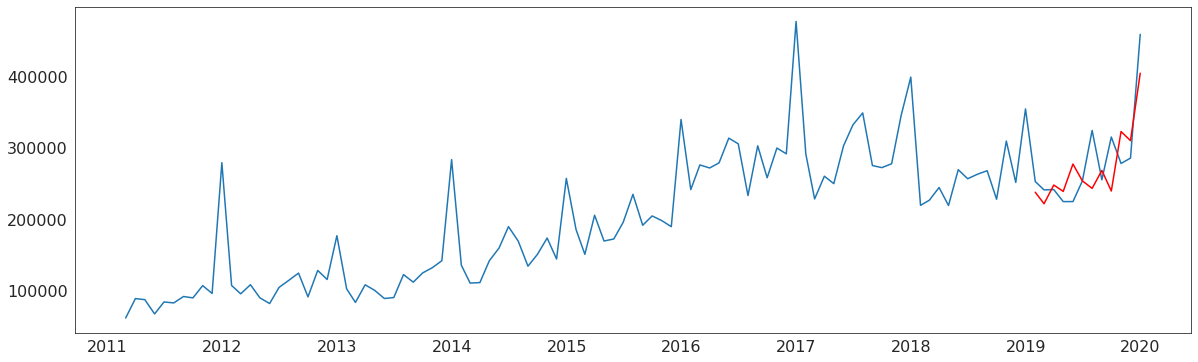

In [293]:
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.plot(from_2011.index.values, from_2011)
ax.plot(pred_sarima.index.values, special.inv_boxcox(pred_sarima, lmbda), color='r');

In [294]:
mse(special.inv_boxcox(pred_sarima, lmbda),from_2011[split_point:], squared=False)

42606.59137697411

__SARIMA model residual (actuals - predicted) acf and pacf plots__

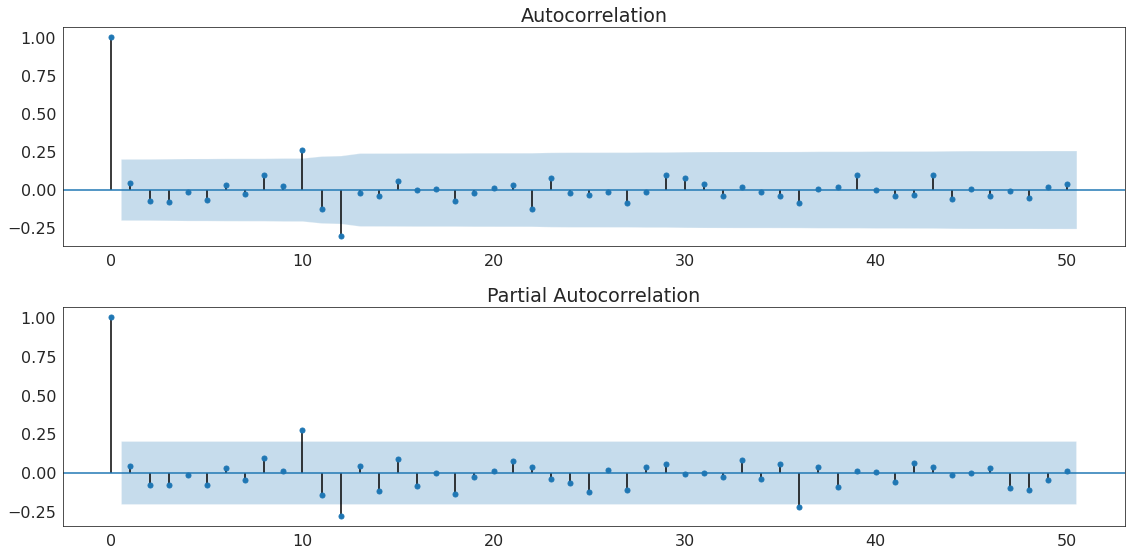

In [295]:
# SARIMA model residual (actuals- predicted) acf and pacf plots
fig, axs = plt.subplots(2, figsize=(16, 8))
_ = plot_acf(transformed_train-sarima_fit.predict(transformed_train.index.min(),transformed_train.index.max()), ax=axs[0], lags = 50)
_ = plot_pacf(transformed_train-sarima_fit.predict(transformed_train.index.min(),transformed_train.index.max()), ax=axs[1], lags= 50, method='ywmle')
plt.tight_layout()

In [296]:
# def inv_diff (df_orig_column,df_diff_column, periods):
#   # Generate np.array for the diff_inv function - it includes first n values(n = 
#   # periods) of original data & further diff values of given periods
#   value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())  # Generate np.array with inverse diff
#   inv_diff_vals = diff_inv(value, periods,1 )[periods:]
#   return inv_diff_vals